In [1]:
from typing import Optional
from tqdm import tqdm
from bisect import insort
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from scipy import sparse

## Чтение данных

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
!ls drive/MyDrive/Datasets/RecSys

data.csv


In [4]:
data = pd.read_csv('drive/MyDrive/Datasets/RecSys/data.csv')

In [5]:
data.drop(columns=["oaid_hash", "banner_id0", "banner_id1",
                   "rate0", "rate1", "g0", "g1", "coeff_sum0",
                   "coeff_sum1"],
          inplace=True)
data.head()

,date_time,zone_id,banner_id,campaign_clicks,os_id,country_id,impressions,clicks
0,2021-09-27 00:01:30.000000,0,0,0,0,0,1,1
1,2021-09-26 22:54:49.000000,1,1,0,0,1,1,1
2,2021-09-26 23:57:20.000000,2,2,3,0,0,1,1
3,2021-09-27 00:04:30.000000,3,3,0,1,1,1,1
4,2021-09-27 00:06:21.000000,4,4,0,1,0,1,1


Переведём столбец `date_time` из строчного формата в `datetime`.

In [6]:
data["date_time"] = pd.to_datetime(data["date_time"])
data["date_time"].min(), data["date_time"].max()

(Timestamp('2021-09-01 00:02:49'), Timestamp('2021-10-02 23:59:59'))

Найдём строчки, соответствующие самому позднему дню и выделим их в тестовый датасет

In [7]:
last_date = data["date_time"].max().date()
mask = data["date_time"].dt.date == last_date
test_frac = mask.sum() / len(data)
print(f"Последнему дню соответствует {test_frac*100:.1f}% данных")

Последнему дню соответствует 13.5% данных


In [8]:
df = data.loc[~mask, :]
df_test = data.loc[mask, :]
print(df.shape, df_test.shape)

(13692494, 8) (2128978, 8)


In [9]:
del data
gc.collect()

88

## Визуализация данных

Вспомогательная функция для визуализации распределения значений, которые принимает признак, и среднего числа кликов, соответствующих каждому значению.

In [10]:
def plot_counts_mean(df: pd.DataFrame, col_name: str):
    grouped = df[[col_name, "clicks"]].groupby(col_name)
    x = list(grouped.groups.keys())
    counts = grouped.size()
    means = grouped.mean()

    plt.figure(figsize=(6, 6))
    plt.subplot(211)
    plt.semilogy(counts.index, counts.values, color="tab:blue")
    plt.ylabel("Counts")
    plt.subplot(212)
    plt.plot(means.index, means.values, color="tab:orange")
    plt.ylabel("Avg. clicks")
    plt.xlabel(col_name)
    plt.tight_layout()
    plt.show()

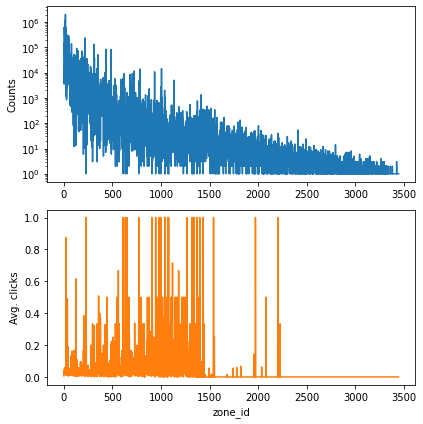

In [11]:
plot_counts_mean(df, "zone_id")

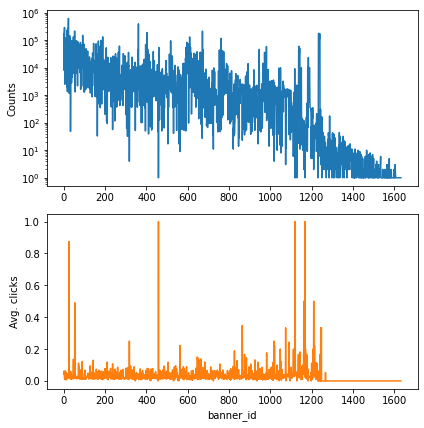

In [12]:
plot_counts_mean(df, "banner_id")

Видно, что как `zone_id`, так и `banner_id` принимают большое число значений. По распределениям видно, что "величина" id вряд ли может быть полезным признаком для линейной модели.

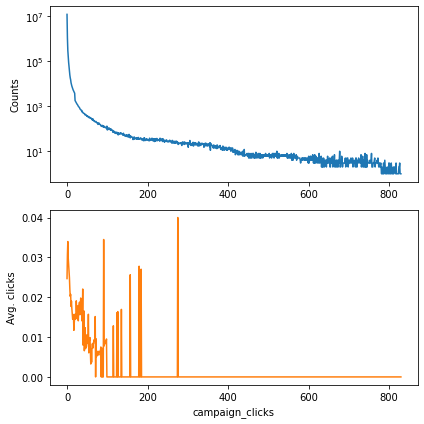

In [13]:
plot_counts_mean(df, "campaign_clicks")

Распределение `campaign_clicks` неравномерно -- больших значений существенно меньше, чем малых. В таком случае имеет смысл взять логарифм данного признака.

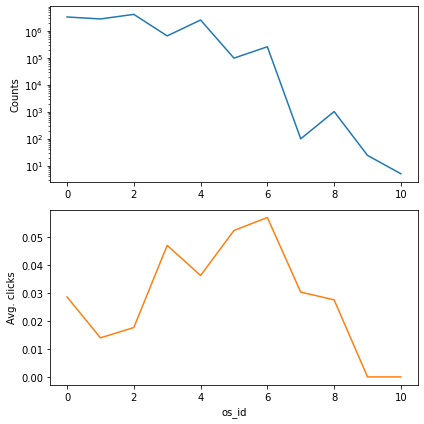

In [14]:
plot_counts_mean(df, "os_id")

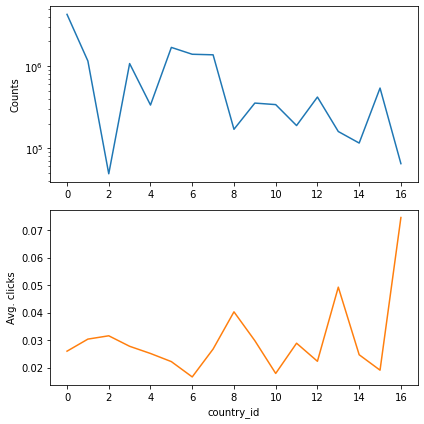

In [15]:
plot_counts_mean(df, "country_id")

Признаки `os_id` и `country_id` принимают небольшо число значений. В таком случае логично использовать OneHot кодирование.

In [16]:
pd.unique(df["impressions"])

array([1])

Признак `impressions` принимает только 1 значение, так что его можно выкинуть.

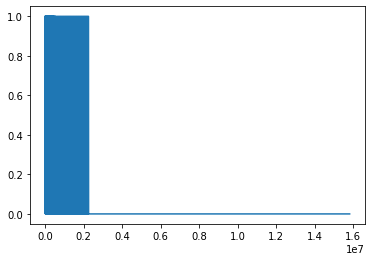

In [17]:
plt.plot(df["clicks"])

Все данные с `clicks == 1` сосредоточены в начальной части датасета. Поэтому к делению датасета на тренировочный и валидационный следует подходить аккуратно -- использовать stratified алгоритм.

In [18]:
plt.close("all")

## Выбор признаков

In [19]:
df.head()

,date_time,zone_id,banner_id,campaign_clicks,os_id,country_id,impressions,clicks
0,2021-09-27 00:01:30,0,0,0,0,0,1,1
1,2021-09-26 22:54:49,1,1,0,0,1,1,1
2,2021-09-26 23:57:20,2,2,3,0,0,1,1
3,2021-09-27 00:04:30,3,3,0,1,1,1,1
4,2021-09-27 00:06:21,4,4,0,1,0,1,1


Из столбца со временем выберем день недели и час.

In [20]:
def process_date_time(df: pd.DataFrame) -> pd.DataFrame:
    df_dt = pd.DataFrame(columns=["weekday", "hour"])
    df_dt["weekday"] = df["date_time"].dt.weekday
    df_dt["hour"] = df["date_time"].dt.hour
    return df_dt

In [21]:
date_time_train = process_date_time(df)
date_time_test = process_date_time(df_test)

date_time_train.describe()

,weekday,hour
count,1.369249e+07,1.369249e+07
mean,2.767323e+00,1.313662e+01
std,2.124162e+00,6.716890e+00
min,0.000000e+00,0.000000e+00
25%,1.000000e+00,8.000000e+00
50%,2.000000e+00,1.500000e+01
75%,4.000000e+00,1.900000e+01
max,6.000000e+00,2.300000e+01


Для идентификаторов логично использовать one-hot кодирование. При этом у `zone_id` и `banner_id` имеется очень много значений, многие из которых являются редкими. Поэтому выберм только по 100 самых частых id, а остальные объединим в одну группу.

Соответствующий функционал присутствует в *scikit-learn v1.1*, но эта версия мне сейчас недоступна. Поэтому будем испоьзовать самодельный аналог.

In [22]:
class OneHotEncoder:
    def __init__(self, max_labels: Optional[int] = 100, fill_value: int = -1):
        self.max_labels = max_labels
        self.fill_value = fill_value
        self.encoded_values = None

    def fit(self, df: pd.DataFrame, col_name: str):
        nc_vals = []  # [(-count, value), ...]
        for value, count in df[col_name].value_counts().items():
            t = (-count, value)
            if (self.max_labels is None) or (len(nc_vals) < self.max_labels) \
                    or (t < nc_vals[-1]):
                insort(nc_vals, t)
                if self.max_labels and len(nc_vals) > self.max_labels:
                    nc_vals.pop()
        self.encoded_values = sorted(v for _, v in nc_vals)


    def transform(self, df: pd.DataFrame, col_name: str):
        def get_col_name(value):
            return f"{col_name}_{value}"

        all_values = [self.fill_value] + self.encoded_values
        col_names = [get_col_name(v) for v in all_values]
        v2c = {v: f"{col_name}_{v}" for v in all_values}

        dummies = pd.DataFrame(
            data=np.zeros((len(df), len(col_names)), dtype=np.uint8),
            index=df.index,
            columns=col_names
        )
        for value, inds in df.groupby(col_name).groups.items():
            if value not in v2c:
                dummies.loc[inds, col_names[0]] = 1
            else:
                dummies.loc[inds, v2c[value]] = 1
              
        return sparse.coo_matrix(dummies.values)

In [23]:
enc = OneHotEncoder(max_labels=100)
enc.fit(df, "zone_id")

zone_id_train = enc.transform(df, "zone_id")
zone_id_test = enc.transform(df_test, "zone_id")

zone_id_train, zone_id_test

(<13692494x101 sparse matrix of type '<class 'numpy.uint8'>'
 	with 13692494 stored elements in COOrdinate format>,
 <2128978x101 sparse matrix of type '<class 'numpy.uint8'>'
 	with 2128978 stored elements in COOrdinate format>)

In [24]:
enc = OneHotEncoder(max_labels=100)
enc.fit(df, "banner_id")

banner_id_train = enc.transform(df, "banner_id")
banner_id_test = enc.transform(df_test, "banner_id")

banner_id_train, banner_id_test

(<13692494x101 sparse matrix of type '<class 'numpy.uint8'>'
 	with 13692494 stored elements in COOrdinate format>,
 <2128978x101 sparse matrix of type '<class 'numpy.uint8'>'
 	with 2128978 stored elements in COOrdinate format>)

Возьмем логарифм от числа `campaign_clicks`, чтобы немного сбалансировать распределение значений.

In [25]:
log_campaign_clicks_train = np.log10(df["campaign_clicks"].to_numpy() + 1)
log_campaign_clicks_test = np.log10(df_test["campaign_clicks"].to_numpy() + 1)

Для `os_id` и `country_id`, как и для других id, будем использовать one-hot кодирование. Из операционных систем возьмем только 7 наиболее популярных, страны выберем все

In [26]:
enc = OneHotEncoder(max_labels=7)
enc.fit(df, "os_id")
print(enc.encoded_values)

os_id_train = enc.transform(df, "os_id")
os_id_test = enc.transform(df_test, "os_id")

os_id_train, os_id_test

[0, 1, 2, 3, 4, 5, 6]


(<13692494x8 sparse matrix of type '<class 'numpy.uint8'>'
 	with 13692494 stored elements in COOrdinate format>,
 <2128978x8 sparse matrix of type '<class 'numpy.uint8'>'
 	with 2128978 stored elements in COOrdinate format>)

In [27]:
enc = OneHotEncoder(max_labels=None)
enc.fit(df, "country_id")
print(enc.encoded_values)

country_id_train = enc.transform(df, "country_id")
country_id_test = enc.transform(df_test, "country_id")

country_id_train, country_id_test

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


(<13692494x18 sparse matrix of type '<class 'numpy.uint8'>'
 	with 13692494 stored elements in COOrdinate format>,
 <2128978x18 sparse matrix of type '<class 'numpy.uint8'>'
 	with 2128978 stored elements in COOrdinate format>)

Как уже было сказано выше, признак `impressions` неинформативен.

## Линейная модель

Составим из полученных массивов разреженные матрицы для логиситической регрессии.

In [28]:
X = sparse.hstack(
    [date_time_train,
     zone_id_train,
     banner_id_train,
     log_campaign_clicks_train.reshape(-1, 1),
     os_id_train,
     country_id_train],
    format="csr",
    dtype=np.float32
)
y = df["clicks"].to_numpy(dtype=np.float32)

X_test = sparse.hstack(
    [date_time_test,
     zone_id_test,
     banner_id_test,
     log_campaign_clicks_test.reshape(-1, 1),
     os_id_test,
     country_id_test],
    format="csr",
    dtype=np.float32
)
y_test = df_test["clicks"].to_numpy(dtype=np.float32)

In [29]:
del df
del df_test

gc.collect()

110

Выберем оптимальное значение параметра регуляризации $C$ с помощью кросс-валидации.

In [30]:
N_SPLITS = 5
N_C = 6


skf = StratifiedKFold(N_SPLITS)
c_vals = np.logspace(-4, 4, N_C)
train_losses = np.zeros((N_C, N_SPLITS))
val_losses = np.zeros_like(train_losses)

for i, ci in enumerate(c_vals):
    model = LogisticRegression(solver="liblinear", C=ci)

    for j, (train_index, val_index) in tqdm(enumerate(skf.split(X, y))):
        model.fit(X[train_index], y[train_index])

        pred_train = model.predict_proba(X[train_index])[:, 1]
        train_loss = log_loss(y[train_index], pred_train)
        pred_val = model.predict_proba(X[val_index])[:, 1]
        val_loss = log_loss(y[val_index], pred_val)

        train_losses[i, j] = train_loss
        val_losses[i, j] = val_loss

    print(f"C = {ci:.2e}, train_loss = {train_losses[i].mean():.2e}, " +
          f"val_loss = {val_losses[i].mean():.2e}")

5it [02:11, 26.21s/it]


C = 1.00e-04, train_loss = 1.12e-01, val_loss = 1.17e-01


5it [03:47, 45.55s/it]


C = 3.98e-03, train_loss = 1.07e-01, val_loss = 1.14e-01


5it [05:22, 64.54s/it]


C = 1.58e-01, train_loss = 1.06e-01, val_loss = 1.14e-01


5it [05:53, 70.69s/it]


C = 6.31e+00, train_loss = 1.06e-01, val_loss = 1.14e-01


5it [05:40, 68.00s/it]


C = 2.51e+02, train_loss = 1.06e-01, val_loss = 1.14e-01


5it [05:32, 66.46s/it]

C = 1.00e+04, train_loss = 1.06e-01, val_loss = 1.14e-01


Видно, что в целом модели не хватает сложности, поэтому регуляризация не оказывает существенного эффекта. Выберем $C = 5$ и обучим модель на всей обучающей выборке.

In [31]:
model = LogisticRegression(solver="liblinear", C=5.0)
model.fit(X, y)
pred_train = model.predict_proba(X)[:, 1]
pred_train

array([0.00592954, 0.05130269, 0.04717894, ..., 0.01309706, 0.03584908,
       0.01049481])

In [32]:
log_loss(y, pred_train)

0.10704907266201868

In [33]:
pred_test = model.predict_proba(X_test)[:, 1]
log_loss(y_test, pred_test)

0.13499322481373163

Сравним с бейзлайном

In [34]:
avg_clicks = y.mean()
avg_clicks

0.0253341

In [35]:
log_loss(y, np.full(y.shape, avg_clicks))

0.11812858559951384

In [36]:
log_loss(y_test, np.full(y_test.shape, avg_clicks))

0.15486200454645255